In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/NSL-KDD/kdd_train.csv")
test = pd.read_csv("/content/drive/MyDrive/NSL-KDD/kdd_test.csv")

In [ ]:
train.shape, test.shape

((125973, 42), (22544, 42))

In [ ]:
df = pd.concat([train,test])

In [ ]:
df.shape

(148517, 43)

In [ ]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }
df['attack_class'] = df['labels'].map(mapping)

In [ ]:
dist = df['attack_class'].value_counts()
for name, count in dist.iteritems():
    print(f"Number of data points in class: {name.center(17)} is", end = ' ')
    print(f"{count} ({np.round(count / sum(dist) * 100, 3)}%)")

Number of data points in class:       Normal      is 78588 (52.915%)
Number of data points in class:        DoS        is 54022 (36.374%)
Number of data points in class:       Probe       is 13813 (9.301%)
Number of data points in class:        R2L        is 1963 (1.322%)
Number of data points in class:        U2R        is 131 (0.088%)


In [ ]:
def bar_graph(feature):
    df[feature].value_counts().plot(kind="bar")

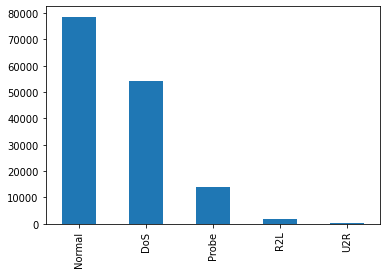

In [ ]:
bar_graph('attack_class')

In [ ]:
X, y = df.drop(['attack_class','labels'],axis=1), df['attack_class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((103961, 30), (44556, 30))

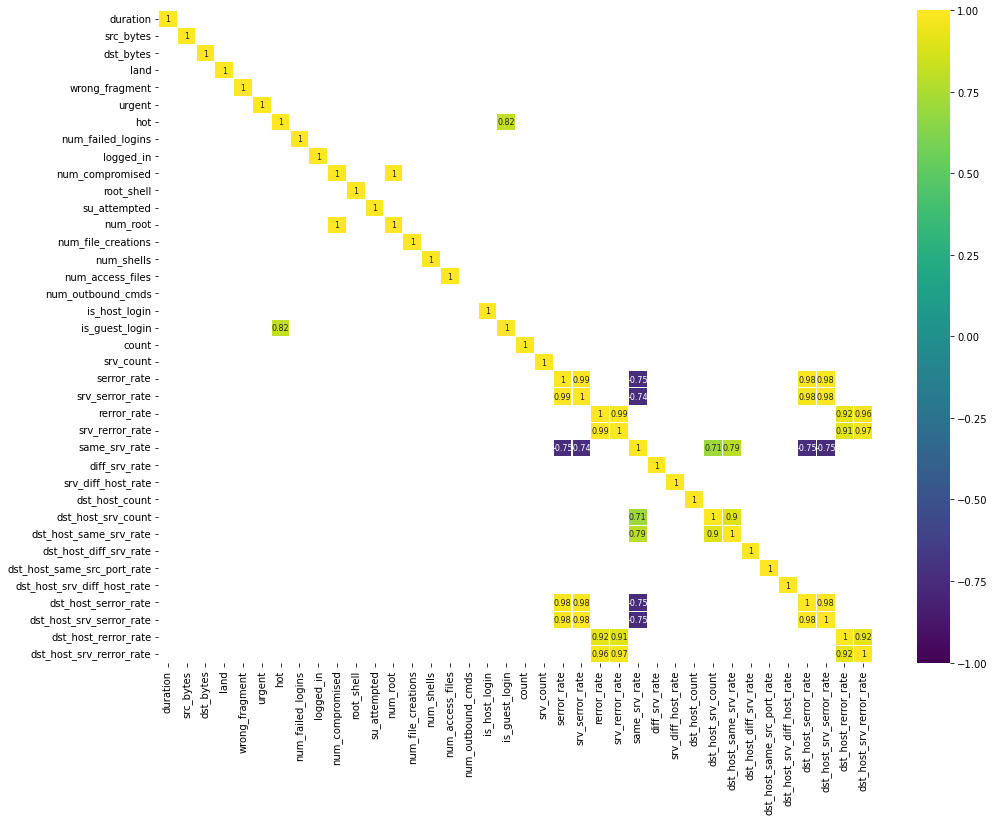

In [ ]:
plt.figure(figsize=(16,12))
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix[(corr_matrix >= 0.7) | (corr_matrix <= -0.7)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8})

In [ ]:
def correlation(dataset, threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        col_corr.add(corr_matrix.columns[i])
  return col_corr

In [ ]:
corr_features = correlation(X_train,0.7)
len(set(corr_features))

11

In [ ]:
corr_features

{'dst_host_rerror_rate',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_count',
 'dst_host_srv_rerror_rate',
 'dst_host_srv_serror_rate',
 'is_guest_login',
 'num_root',
 'same_srv_rate',
 'srv_rerror_rate',
 'srv_serror_rate'}

In [ ]:
X_train = X_train.drop(corr_features,axis=1)
X_test = X_test.drop(corr_features,axis=1)

In [ ]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

dt_cross_scores = cross_val_score(DecisionTreeClassifier(),X_train,y_train,cv=5)
knn_cross_scores = cross_val_score(KNeighborsClassifier(),X_train,y_train,cv=5)

print("Decision Tree Average Cross Valdiation Score: ",dt_cross_scores.mean())
print("KNN Cross Valdiation Score: ",knn_cross_scores.mean())

Decision Tree Average Cross Valdiation Score:  0.9964505926027618
KNN Cross Valdiation Score:  0.9934687028500413


In [ ]:
DTree = DecisionTreeClassifier()

DTree.fit(X_train,y_train)

DTscore = DTree.score(X_test,y_test)
print("Decision Tree Classifier Accuracy: ",DTscore)

Decision Tree Classifier Accuracy:  0.9881946314749978


In [ ]:
KNN = KNeighborsClassifier(n_neighbors=7,weights='distance',n_jobs=-1)

KNN.fit(X_train,y_train)

KNNscore= KNN.score(X_test,y_test)
print("KNN Classifier Accuracy: ",KNNscore)

KNN Classifier Accuracy:  0.9897432444564144


In [ ]:
from sklearn.ensemble import BaggingClassifier

dt_bag = BaggingClassifier(base_estimator=DecisionTreeClassifier()).fit(X_train, y_train)
dt_bag_score = dt_bag.score(X_test,y_test)
print("Decision Tree Score after Bagging: ",dt_bag_score)

Decision Tree Score after Bagging:  0.9924589280904929


In [ ]:
knn_bag = BaggingClassifier(base_estimator=KNeighborsClassifier()).fit(X_train, y_train)
knn_bag_score = knn_bag.score(X_test,y_test)
print("KNN Classifier after Bagging: ",knn_bag_score)

KNN Classifier after Bagging:  0.9913591884370231


In [ ]:
from sklearn import metrics
confusion_matrix_Dt = metrics.confusion_matrix(y_train, DTree.predict(X_train))
confusion_matrix_Dt_bag = metrics.confusion_matrix(y_train,dt_bag.predict(X_train))

confusion_matrix_KNN = metrics.confusion_matrix(y_train, KNN.predict(X_train))
confusion_matrix_KNN_bag = metrics.confusion_matrix(y_train,knn_bag.predict(X_train))

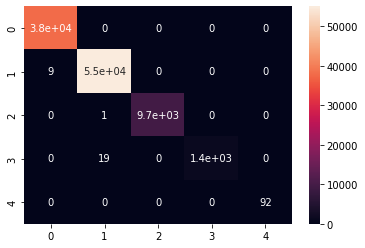

In [ ]:
sns.heatmap(confusion_matrix_Dt,annot=True)

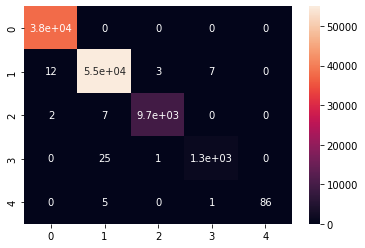

In [ ]:
sns.heatmap(confusion_matrix_Dt_bag,annot=True)

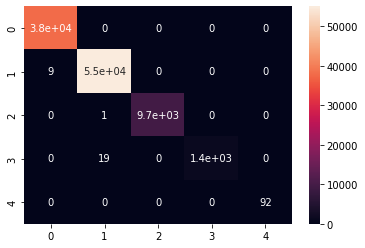

In [ ]:
sns.heatmap(confusion_matrix_KNN,annot=True)

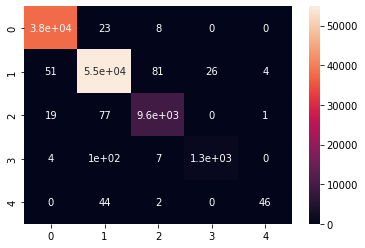

In [ ]:
sns.heatmap(confusion_matrix_KNN_bag,annot=True)

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb.fit(X_train, y_train)

print("Naive Bayes score: ",nb.score(X_test, y_test))

Naive Bayes score:  0.7825208726097496


In [ ]:
nb_bag = BaggingClassifier(base_estimator=GaussianNB()).fit(X_train, y_train)
nb_bag_score = dt_bag.score(X_test,y_test)

In [ ]:
print("Naive Bayes Accuracy after Bagging: ",nb_bag_score)

Naive Bayes Accuracy after Bagging:  0.9924589280904929


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [ ]:
nb_cross_scores = cross_val_score(GaussianNB(),X_res,y_res,cv=5)

print("Naive Bayes Average Cross Valdiation Score: ",nb_cross_scores.mean())

Naive Bayes Average Cross Valdiation Score:  0.722375524895021


In [ ]:
nb = GaussianNB()

nb.fit(X_res, y_res)

print("Naive Bayes score: ",nb.score(X_res, y_res))

Naive Bayes score:  0.7224446019886932


In [ ]:
nb_bag = BaggingClassifier(base_estimator=GaussianNB()).fit(X_res, y_res)
nb_bag_score = dt_bag.score(X_res,y_res)

print("Naive Bayes Score after Bagging: ",nb_bag_score)

Naive Bayes Score after Bagging:  0.9831124684154078
